<center>

# Spam detection

## Alejandra Camelo Cruz

### Matrikelnummer: 800385

</center>


Import modules

In [3]:
#Preprocessing and plotting packages
import scipy.io
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score


create simple function for visualization of data

In [4]:
def pie_plot(data, title):
    unique, counts = np.unique(data, return_counts=True)
    plt.figure(figsize=(8,8))

    plt.pie(
        x=counts,
        labels=['ham', 'spam'],
        autopct='%1.1f%%',
        explode=[0.05, 0.05],
        colors=sns.color_palette('Set2'))

    plt.title(
        label=title,
        pad=20)

    plt.show()


def evaluation(y_test, y_pred, title):
  accuracy = accuracy_score(y_test, y_pred)
  matrix = confusion_matrix(y_test, y_pred)
  matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(16,7))
  sns.set(font_scale=1.4)
  sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)
  class_names = ['ham', 'spam']
  tick_marks = np.arange(len(class_names))
  tick_marks2 = tick_marks + 0.5
  plt.xticks(tick_marks, class_names, rotation=0)
  plt.yticks(tick_marks2, class_names, rotation=0)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title(title)

  print("Accuracy:", accuracy)
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  plt.show()

# Data Handling

## Load data


In [5]:
# Load MATLAB file
mat_data = scipy.io.loadmat('emails.mat')

# Extract data
# I'll work with pandas dataframe
X = pd.DataFrame.sparse.from_spmatrix(mat_data['X'])
X = X.T #attributes are now columns and instances are rows
Y = mat_data['Y'][0]

How do data look like?

In [6]:
# How do data look like?
missing_values = X.isnull().any()
no_missing = missing_values[missing_values.isin([True])].empty
print(f'There are no missing values: {no_missing}')

# Shape of dataframe
print(X.head())
print('shape of data: ', X.shape)

There are no missing values: True
   0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

   57163  57164  57165  57166  57167  57168  57169  57170  57171  57172  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 57173 columns]
shape of data: 

Plot how data are distributed

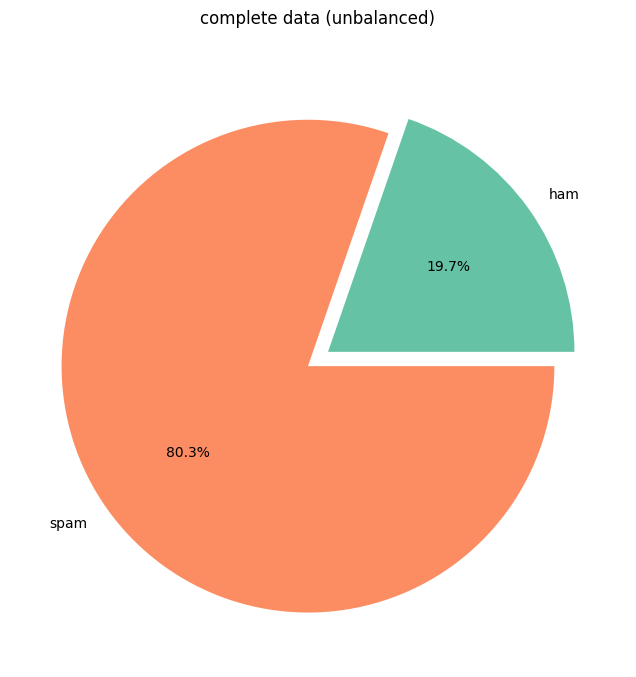

In [7]:
# Plot how data are distributed
pie_plot(Y, 'complete data (unbalanced)')

Data are mild unbalanced. However, I'll check how the model work with original data

In [8]:
# Data is mildly unbalanced but model can be tried
#1. Split train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=4)

# Random forest
## with complete data
Try a first model and see how it performs

1. create a classifier and fit it with training data
2. Make predictions and evaluate model

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


---------------first model evaluation-------------------
Accuracy: 0.9976
[[ 462    6]
 [   0 2032]]
              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       468
           1       1.00      1.00      1.00      2032

    accuracy                           1.00      2500
   macro avg       1.00      0.99      1.00      2500
weighted avg       1.00      1.00      1.00      2500



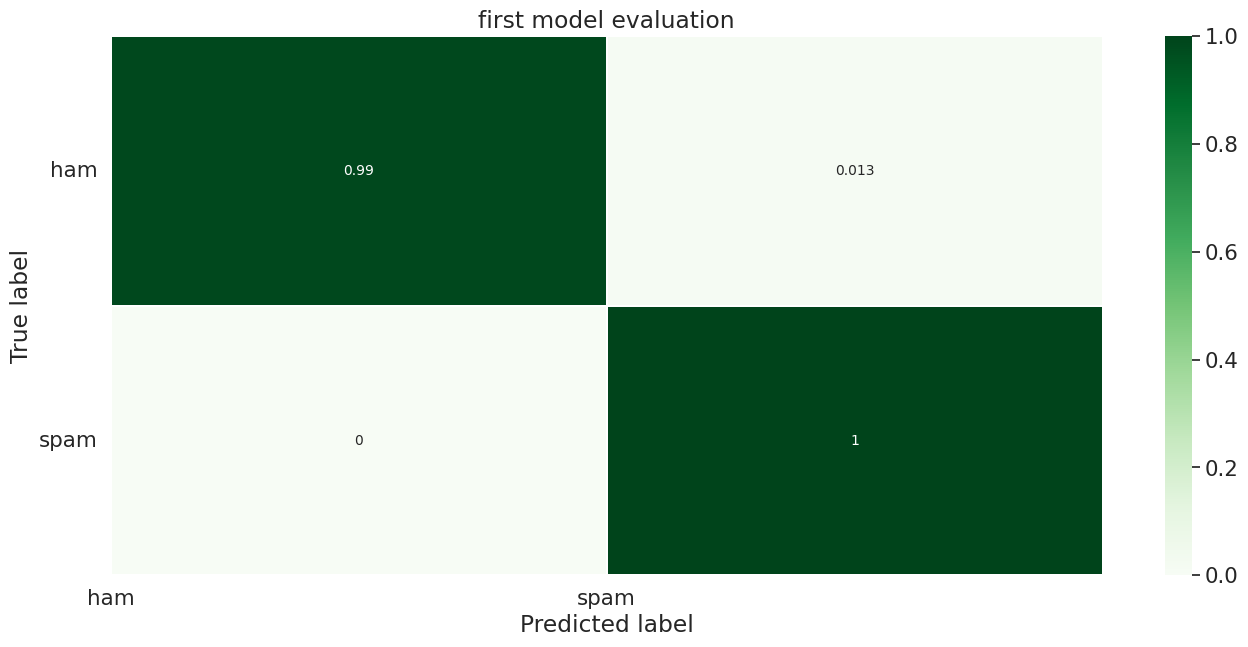

---------------tuned unclean model evaluation-------------------
Accuracy: 0.998
[[ 464    4]
 [   1 2031]]
              precision    recall  f1-score   support

          -1       1.00      0.99      0.99       468
           1       1.00      1.00      1.00      2032

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



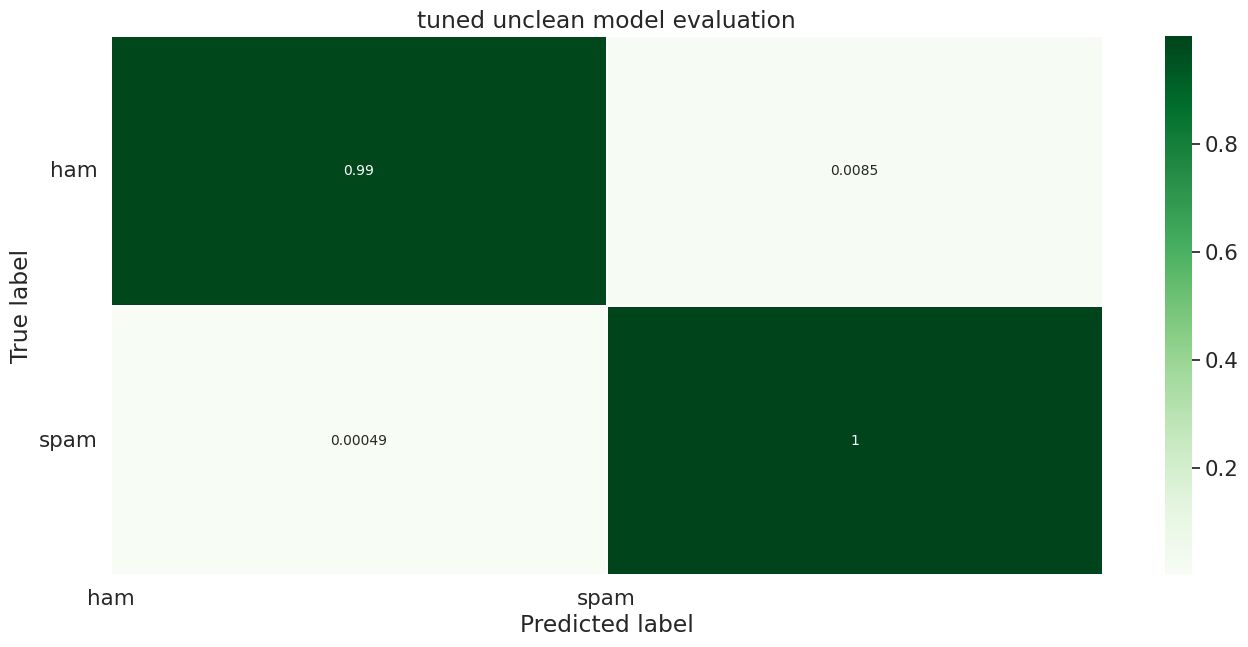

In [9]:
#1. Create and fit classifier
clf = RandomForestClassifier(random_state=4)
clf.fit(x_train, y_train)

#2. best random for unclean data
best_random_unclean = RandomForestClassifier(n_estimators=800,
min_samples_split=2,
min_samples_leaf=1,
max_features='auto',
max_depth=None,
bootstrap=False, random_state=4)

best_random_unclean.fit(x_train, y_train)

#2. Evaluate
y_pred = clf.predict(x_test)
y_pred_unclean = best_random_unclean.predict(x_test)

#evaluate both unclean data
print('---------------first model evaluation-------------------')
evaluation(y_test, y_pred, 'first model evaluation')
print('---------------tuned unclean model evaluation-------------------')
evaluation(y_test, y_pred_unclean, 'tuned unclean model evaluation')

In [10]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 4,
 'verbose': 0,
 'warm_start': False}

# Is the model overfitting? Are there reasons for this behaviour?

Some testing data are already seen in training. Let's see how the model works accounting for some problems

1. duplicated items?

In [15]:
print('number of duplicated elements: ', X.duplicated().sum())

duplicate_rows = X[X.duplicated(keep='first')]
duplicate_indexes = list(duplicate_rows.index)

X_clean = X.drop(duplicate_indexes)
Y_clean = np.delete(Y, duplicate_indexes)

print('X_clean: ', X_clean.shape)
print('Y_clean: ', Y_clean.shape)

number of duplicated elements:  3426
X_clean:  (6574, 57173)
Y_clean:  (6574,)


3. check for better hyperparameters


train model with cleaned data

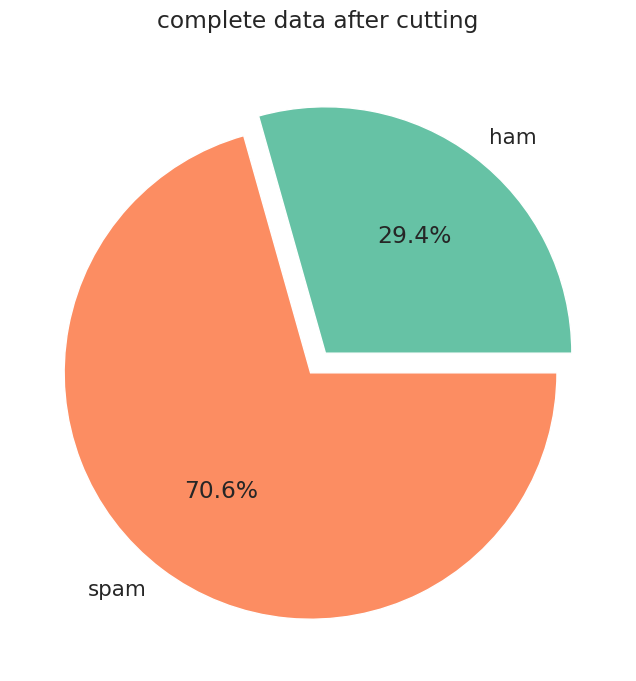

In [16]:
pie_plot(Y_clean, 'complete data after cutting')

x_train_clean, x_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,
                                                                            Y_clean,
                                                                            random_state=4)
#random_grid = { 'bootstrap': [True, False],
#'max_depth': [20, 40, 80, 100, None],
#'max_features': ['auto', 'sqrt'],
#'min_samples_leaf': [1, 2, 4],
#'min_samples_split': [2, 5, 10],
#'n_estimators': [200, 400, 600, 800, 1000]}

#clf = RandomForestClassifier(random_state=4)
#clf_tuned = RandomizedSearchCV(estimator = clf, param_distributions = random_grid,
#                               n_iter = 20, cv = 3, verbose=2,
#                               random_state=4, n_jobs = -1)

In [17]:
#clf_tuned.best_params_

best_random = RandomForestClassifier(n_estimators=400,
min_samples_split=2,
min_samples_leaf=1,
max_features='sqrt',
max_depth=None,
bootstrap=False, random_state=4)
best_random.fit(x_train_clean, y_train_clean)

RandomForestClassifier(bootstrap=False, n_estimators=400, random_state=4)

------tuned clean model evaluation----------
Accuracy: 0.9920924574209246
[[ 466    9]
 [   4 1165]]
              precision    recall  f1-score   support

          -1       0.99      0.98      0.99       475
           1       0.99      1.00      0.99      1169

    accuracy                           0.99      1644
   macro avg       0.99      0.99      0.99      1644
weighted avg       0.99      0.99      0.99      1644



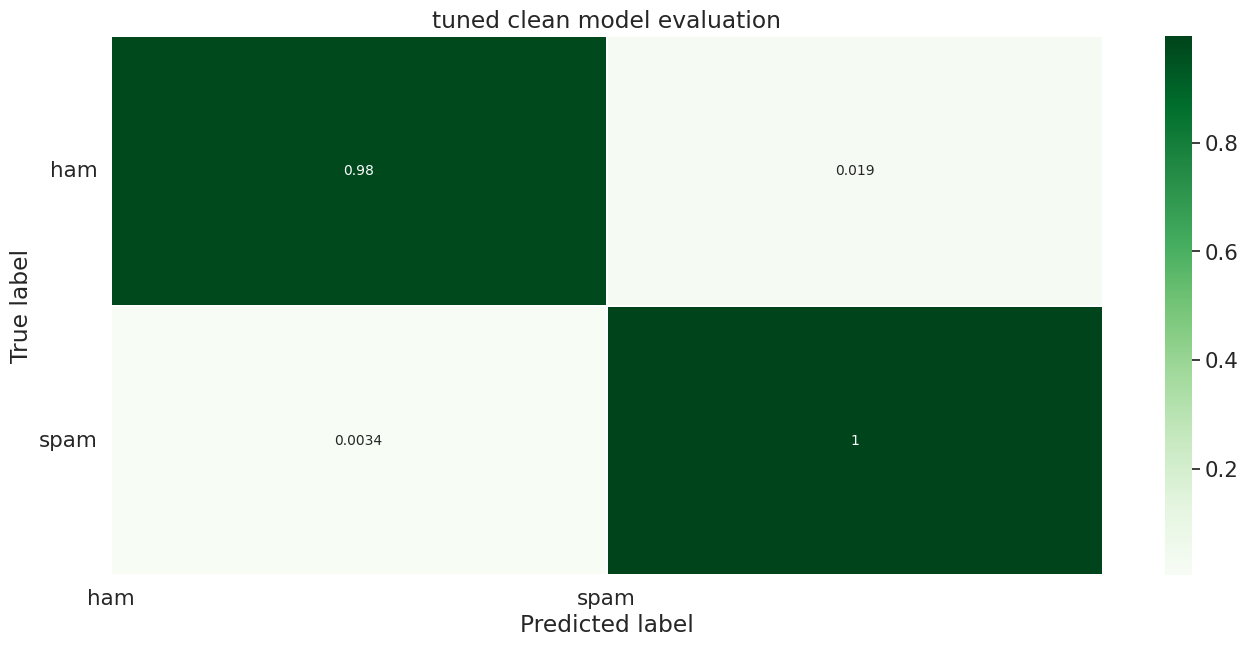

In [18]:
y_pred_tuned = best_random.predict(x_test_clean)

print('------tuned clean model evaluation----------')
evaluation(y_test_clean, y_pred_tuned, 'tuned clean model evaluation')

# Summary


## Evaluation

Data are unbalanced with more spam to non-spam items. As data are unbalanced (more spam than not-spam), these are the decisions made for evaluation protocol

- Precision: important to reduce false positive

- Recall: important to see how many positive predicitions were made

- f1-score: combination between precision recall

In all three case scenarios, even when repeated data points were cutted, the model works well.

## Possible problems

- Sparse data: uninformative attributes might lead to overfitting

- Repeated items might be to overfitting and bad selection of attributes.

- Decreasing number of attributes or items might not display real world data.

##**Text fett markieren** Issues to address

- Why are there repeated items? Is it worthy to cut them off?

- Is it worthy to account for non informative attributes?